# Hackathon Dauphine

### Imports

In [66]:
import pandas as pd
import xgboost
from sklearn.dummy import DummyClassifier
from imblearn.ensemble import BalancedRandomForestClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
import numpy as np
from IPython.display import Image
from sklearn.model_selection import train_test_split
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn import preprocessing, tree, metrics
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score
from imblearn.over_sampling import SMOTE

pd.set_option('display.max_rows', 50)
pd.set_option('display.max_columns', 50)
pd.set_option('display.width', 1000)
%matplotlib inline

### Load Data

In [67]:
df = pd.read_csv("data/ref_phase2_train_x.csv").drop("raw_id", axis=1)
y = pd.read_csv("data/ref_phase2_train_y.csv", header=None, names=["y"])
df_test = pd.read_csv("data/ref_phase2_valid_x.csv").drop("raw_id", axis=1)
df = pd.concat([df, y], axis=1)
DATA = df.copy()

In [68]:
y_train = df["y"]
df_train = df.drop("y", axis=1)

In [69]:
df.head()

,sector,earnings_implied_obs,delta_vol_1w,delta_vol_1y,return_1w,return_1m,return_1y,implied_vol_3m,realised_vol_1w,realised_vol_1m,realised_vol_1y,ratio_put_call,publication_date_funda,exchange,net_income,shareholders_equity,net_debt,ebitda,ebit,sales,cash_flow,payout_ratio,score_env,score_soc,score_gov,y
0,4700,3.7452,-0.3692,-0.0972,2.2375,1.1495,22.1040,17.1714,0.787627,0.884178,1.401695,0.516182,364.0,US,0.018193,1.011748,0.924447,0.306404,0.196460,1.000361,0.245411,265.517241,57.83,55.47,46.20,0
1,4700,3.2026,-0.6008,0.6127,3.3098,1.3508,17.5971,15.9524,0.939068,0.833054,1.370815,0.540048,66.0,US,0.065461,0.998823,0.836746,0.280513,0.173050,0.950767,0.225520,72.325581,58.41,55.24,49.96,0
2,4700,4.4641,1.6247,-5.4056,-0.6884,-2.3511,6.2714,16.4591,0.959970,0.714396,0.907072,0.558759,255.0,US,0.065711,1.002628,0.839933,0.281582,0.173709,0.954389,0.226379,72.325581,57.15,53.86,53.23,0
3,4700,5.4850,0.3439,-0.4482,1.5906,5.5010,9.4912,15.9525,0.503026,0.593907,0.877211,0.798445,358.0,US,0.064607,0.985790,0.825828,0.276853,0.170792,0.938362,0.222578,72.325581,58.28,53.79,54.67,0
4,4700,2.3555,0.4032,-1.2826,1.4269,4.4619,17.4692,14.4131,0.947279,0.994358,0.876525,0.693418,62.0,US,-0.111328,0.756207,0.759751,0.252945,0.154876,0.779753,0.197967,72.325581,57.88,53.49,54.43,0


# Explore DATA

In [70]:
#Projection des données globales :
# df.hist(bins=50, figsize=(20,15))
# plt.savefig("images/figure.png")
# plt.show()
Image(url= "images/figure.png")

# Outliers

In [71]:
# df = df.loc[df['net_income']!=df['net_income'].min()];
# df = df.loc[df['delta_vol_1w']!=df['delta_vol_1w'].max()];
# df = df.loc[df['delta_vol_1w']!=df['delta_vol_1w'].max()];

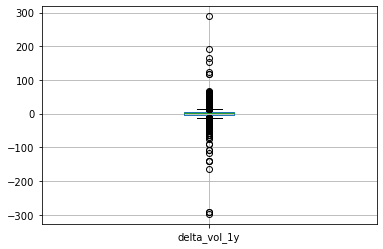

In [72]:
df.boxplot("delta_vol_1y")

### Sector en STR

In [73]:
df_train['sector'] = df_train['sector'].astype(str)
df_test['sector'] = df_test['sector'].astype(str)

### NaNs

In [74]:
from sklearn.impute import KNNImputer
from sklearn import preprocessing

def fill_na(df, knn=5):
    df_num = df[list(df.describe())]
    
    columns_full = list(df)
    columns_numerical = list(df_num)
    columns_categorical = [x for x in columns_full if x not in columns_numerical]
    df_categorical = df[columns_categorical]

    imputer = KNNImputer(n_neighbors=5)
    df_num_treated = imputer.fit_transform(df_num)
    df_num_treated = pd.DataFrame(df_num_treated, columns = columns_numerical)
    
    df_full_treated = pd.concat([df_num_treated, df_categorical], axis=1)[columns_full]
    return(df_full_treated)

In [75]:
df_train = fill_na(df_train)
df_test = fill_na(df_test)

# Categorical

#### Sous-sector

#### Sector + Exchange Encoding

In [76]:
df_train

,sector,earnings_implied_obs,delta_vol_1w,delta_vol_1y,return_1w,return_1m,return_1y,implied_vol_3m,realised_vol_1w,realised_vol_1m,realised_vol_1y,ratio_put_call,publication_date_funda,exchange,net_income,shareholders_equity,net_debt,ebitda,ebit,sales,cash_flow,payout_ratio,score_env,score_soc,score_gov
0,4700,3.7452,-0.3692,-0.0972,2.2375,1.1495,22.1040,17.1714,0.787627,0.884178,1.401695,0.516182,364.0,US,0.018193,1.011748,0.924447,0.306404,0.196460,1.000361,0.245411,265.517241,57.83,55.47,46.20
1,4700,3.2026,-0.6008,0.6127,3.3098,1.3508,17.5971,15.9524,0.939068,0.833054,1.370815,0.540048,66.0,US,0.065461,0.998823,0.836746,0.280513,0.173050,0.950767,0.225520,72.325581,58.41,55.24,49.96
2,4700,4.4641,1.6247,-5.4056,-0.6884,-2.3511,6.2714,16.4591,0.959970,0.714396,0.907072,0.558759,255.0,US,0.065711,1.002628,0.839933,0.281582,0.173709,0.954389,0.226379,72.325581,57.15,53.86,53.23
3,4700,5.4850,0.3439,-0.4482,1.5906,5.5010,9.4912,15.9525,0.503026,0.593907,0.877211,0.798445,358.0,US,0.064607,0.985790,0.825828,0.276853,0.170792,0.938362,0.222578,72.325581,58.28,53.79,54.67
4,4700,2.3555,0.4032,-1.2826,1.4269,4.4619,17.4692,14.4131,0.947279,0.994358,0.876525,0.693418,62.0,US,-0.111328,0.756207,0.759751,0.252945,0.154876,0.779753,0.197967,72.325581,57.88,53.49,54.43
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19435,2200,3.0493,-1.2197,-5.0665,-1.7550,-3.8684,10.6195,22.7262,0.781925,0.798688,1.283124,0.577849,167.0,US,0.036748,0.264873,0.579228,0.213936,0.139168,1.267426,0.101511,0.000000,53.45,51.32,44.69
19436,2200,3.9732,0.8920,1.1991,-4.9254,-16.5272,-28.0954,29.1528,1.940011,1.699516,1.672743,0.641036,355.0,US,0.052549,0.378768,0.828294,0.305928,0.199009,1.812413,0.145160,0.000000,53.99,51.37,37.48
19437,2200,3.5993,-0.8110,2.5070,1.4117,3.6775,-21.2728,26.1781,0.794124,1.011044,1.717660,0.397166,77.0,US,0.019151,0.295688,0.752754,0.282411,0.171336,1.732254,0.194061,0.000000,52.63,51.98,37.98
19438,2200,3.3735,1.9479,4.2583,-5.2846,-13.9313,-36.3466,27.4175,1.067867,1.303602,1.858680,0.385450,169.0,US,0.021931,0.338616,0.862038,0.323410,0.196210,1.983740,0.222235,0.000000,62.60,55.76,42.61


In [77]:
import category_encoders as ce
def encode(df):
    encoder = ce.OneHotEncoder(cols=['sector'])
    df = encoder.fit_transform(df)

    encoder = ce.OrdinalEncoder(cols=['exchange'])
    df = encoder.fit_transform(df)
    return(df)

In [78]:
df_train = encode(df_train)
df_test = encode(df_test)
df_train

,sector_1,sector_2,sector_3,sector_4,sector_5,sector_6,sector_7,sector_8,sector_9,sector_10,sector_11,sector_12,sector_13,sector_14,sector_15,sector_16,sector_17,sector_18,sector_19,sector_20,earnings_implied_obs,delta_vol_1w,delta_vol_1y,return_1w,return_1m,return_1y,implied_vol_3m,realised_vol_1w,realised_vol_1m,realised_vol_1y,ratio_put_call,publication_date_funda,exchange,net_income,shareholders_equity,net_debt,ebitda,ebit,sales,cash_flow,payout_ratio,score_env,score_soc,score_gov
0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3.7452,-0.3692,-0.0972,2.2375,1.1495,22.1040,17.1714,0.787627,0.884178,1.401695,0.516182,364.0,1,0.018193,1.011748,0.924447,0.306404,0.196460,1.000361,0.245411,265.517241,57.83,55.47,46.20
1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3.2026,-0.6008,0.6127,3.3098,1.3508,17.5971,15.9524,0.939068,0.833054,1.370815,0.540048,66.0,1,0.065461,0.998823,0.836746,0.280513,0.173050,0.950767,0.225520,72.325581,58.41,55.24,49.96
2,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4.4641,1.6247,-5.4056,-0.6884,-2.3511,6.2714,16.4591,0.959970,0.714396,0.907072,0.558759,255.0,1,0.065711,1.002628,0.839933,0.281582,0.173709,0.954389,0.226379,72.325581,57.15,53.86,53.23
3,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,5.4850,0.3439,-0.4482,1.5906,5.5010,9.4912,15.9525,0.503026,0.593907,0.877211,0.798445,358.0,1,0.064607,0.985790,0.825828,0.276853,0.170792,0.938362,0.222578,72.325581,58.28,53.79,54.67
4,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2.3555,0.4032,-1.2826,1.4269,4.4619,17.4692,14.4131,0.947279,0.994358,0.876525,0.693418,62.0,1,-0.111328,0.756207,0.759751,0.252945,0.154876,0.779753,0.197967,72.325581,57.88,53.49,54.43
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19435,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,3.0493,-1.2197,-5.0665,-1.7550,-3.8684,10.6195,22.7262,0.781925,0.798688,1.283124,0.577849,167.0,1,0.036748,0.264873,0.579228,0.213936,0.139168,1.267426,0.101511,0.000000,53.45,51.32,44.69
19436,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,3.9732,0.8920,1.1991,-4.9254,-16.5272,-28.0954,29.1528,1.940011,1.699516,1.672743,0.641036,355.0,1,0.052549,0.378768,0.828294,0.305928,0.199009,1.812413,0.145160,0.000000,53.99,51.37,37.48
19437,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,3.5993,-0.8110,2.5070,1.4117,3.6775,-21.2728,26.1781,0.794124,1.011044,1.717660,0.397166,77.0,1,0.019151,0.295688,0.752754,0.282411,0.171336,1.732254,0.194061,0.000000,52.63,51.98,37.98
19438,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,3.3735,1.9479,4.2583,-5.2846,-13.9313,-36.3466,27.4175,1.067867,1.303602,1.858680,0.385450,169.0,1,0.021931,0.338616,0.862038,0.323410,0.196210,1.983740,0.222235,0.000000,62.60,55.76,42.61


# Smote

In [79]:
# s = SMOTE()
# df_train, y_train = s.fit_resample(df_train,y_train)

# Model

In [80]:
X_train, X_test, Y_train, Y_test = train_test_split(df_train, y_train, test_size=0.33, random_state=42)

### Méthode de Soumission :

#### Cross-Val Score

In [81]:
xgb = xgboost.XGBClassifier(n_estimator = 1000, eval_metric="auc", silent = True)
xgb.fit(X_train, Y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, eval_metric='auc',
              gamma=0, learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimator=1000,
              n_estimators=100, n_jobs=1, nthread=None,
              objective='binary:logistic', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
              subsample=1, verbosity=1)

In [82]:
def test_model(model):
    model.fit(X_train, Y_train)
    Y_pred = model.predict_proba(X_test)[:,1]
    score = roc_auc_score(Y_test, Y_pred)
    return score

In [38]:
def test_model_cv(model, n=5):
    score = cross_val_score(model, df_train, y_train, cv=n)
    return score

### Algorithmes :

In [19]:
dummy_clf = DummyClassifier();
test_model(dummy_clf)

C:\Users\axeld\Anaconda3\lib\site-packages\sklearn\dummy.py:132: FutureWarning: The default value of strategy will change from stratified to prior in 0.24.
  "stratified to prior in 0.24.", FutureWarning)


0.5062107899519256

In [20]:
clf = RandomForestClassifier()
test_model(clf)

0.6513013637103172

In [21]:
RF_B = BalancedRandomForestClassifier(n_jobs = -1, criterion = 'gini')
test_model(RF_B)

0.6523862260797898

In [22]:
clf = RandomForestClassifier()
clf.fit(X_train, Y_train);

In [23]:
test_model(clf)

0.6496625745096919

In [24]:
test_model_cv(clf)

array([0.75316699, 0.75278311, 0.7547025 , 0.75239923, 0.7515361 ])

# Choix de XGBoost

In [25]:
xgb = xgboost.XGBClassifier(n_estimator = 100000, eval_metric="auc", silent = True)
test_model(xgb)

0.5966102919328831

In [26]:
test_model_cv(xgb)

array([0.72975048, 0.73051823, 0.72821497, 0.72975048, 0.72849462])

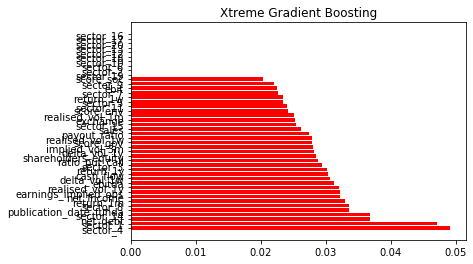

In [27]:
xgb = xgboost.XGBClassifier(n_estimator = 10000, eval_metric="auc", silent = True)
xgb.fit(X_train, Y_train)

importances = xgb.feature_importances_

# Sort feature importances in descending order
indices = np.argsort(importances)[::-1]

# Rearrange features names so they match the sorted feature importances
names = [list(X_train)[i] for i in indices]

# Create plot
plt.figure()
plt.title("Xtreme Gradient Boosting")
plt.barh(range(X_train.shape[1]), importances[indices], color="r", align="center")
plt.yticks(range(X_train.shape[1]), names)

# Show plot
plt.show()

# Grid Search

In [28]:
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import RandomizedSearchCV
from datetime import datetime

In [29]:
def timer(start_time=None):
    if not start_time:
        start_time = datetime.now()
        return start_time
    elif start_time:
        thour, temp_sec = divmod((datetime.now() - start_time).total_seconds(), 3600)
        tmin, tsec = divmod(temp_sec, 60)
        print('\n Time taken: %i hours %i minutes and %s seconds.' % (thour, tmin, round(tsec, 2)))

In [30]:
# A parameter grid for XGBoost
params = {
        'min_child_weight': [1, 4, 10],
        'gamma': [0.5, 1, 1.5, 2.5, 5],
        'subsample': [0.5, 0.8, 1.2],
        'colsample_bytree': [0.6, 0.8, 1.0],
        'max_depth': [3, 4, 5]
        }
# Best hyperparameters:
# {'subsample': 0.8, 'min_child_weight': 4, 'max_depth': 5, 'gamma': 1, 'colsample_bytree': 0.8}

In [31]:
xgb = xgboost.XGBClassifier(learning_rate=0.02, n_estimators=3000, eval_metric="auc",
                    silent=True, nthread=1)

In [32]:
# folds = 3
# param_comb = 5

# skf = StratifiedKFold(n_splits=folds, shuffle = True, random_state = 1001)

# random_search = RandomizedSearchCV(xgb, param_distributions=params, n_iter=param_comb,
#                                    scoring='roc_auc', n_jobs=4, cv=skf.split(X_train,Y_train),
#                                    verbose=3, random_state=1001)

# # Here we go
# start_time = timer(None) # timing starts from this point for "start_time" variable
# random_search.fit(X_train, Y_train)
# timer(start_time) # timing ends here for "start_time" variable

In [34]:
# print('\n All results:')
# print(random_search.cv_results_)
# print('\n Best estimator:')
# print(random_search.best_estimator_)
# print('\n Best normalized gini score for %d-fold search with %d parameter combinations:' % (folds, param_comb))
# print(random_search.best_score_ * 2 - 1)
# print('\n Best hyperparameters:')
# print(random_search.best_params_)
# results = pd.DataFrame(random_search.cv_results_)
# results.to_csv('xgb-random-grid-search-results-01.csv', index=False)

In [ ]:
tuned_xgb1 = random_search.best_estimator_

In [35]:
# Best hyperparameters:
# {'subsample': 0.8, 'min_child_weight': 4, 'max_depth': 5, 'gamma': 1, 'colsample_bytree': 0.8}
tuned_xgb = xgboost.XGBClassifier(learning_rate=0.02, n_estimators=3000, eval_metric="auc",subsample=0.8, min_child_weight=4, max_depth=5,
                            gamma=1, colsample_bytree=0.8,
                            silent=True, nthread=1)
tuned_xgb.fit(X_train, Y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.8, eval_metric='auc',
              gamma=1, learning_rate=0.02, max_delta_step=0, max_depth=5,
              min_child_weight=4, missing=None, n_estimators=3000, n_jobs=1,
              nthread=1, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=True, subsample=0.8, verbosity=1)

In [36]:
y_predict_tuned_xgb = tuned_xgb.predict_proba(X_test)[:,1]
np.savetxt("out_xgbbb.csv", y_predict_tuned_xgb, delimiter = ".")

In [37]:
score = roc_auc_score(Y_test, y_predict_tuned_xgb)
score

0.6352366061585256

# Submit Model

In [93]:
def submit_model(model, name="pred", test_set=df_test):
    name = "submissions/"+name+".csv"
    model.fit(df_train, y_train)
    y_pred = model.predict_proba(test_set)[:,1]
    y_pred = pd.DataFrame(y_pred, columns=["pred"])
    y_pred.to_csv(name, header=False, index=False)
    return y_pred

In [94]:
# submit_model(clf, "randomForest")

,pred
0,0.07
1,0.11
2,0.08
3,0.47
4,0.40
...,...
3740,0.30
3741,0.42
3742,0.42
3743,0.33


In [95]:
tuned_xgb = xgboost.XGBClassifier(learning_rate=0.02, n_estimators=3000, eval_metric="auc",subsample=0.8, min_child_weight=4, max_depth=5,
                            gamma=1, colsample_bytree=0.8,
                            silent=True, nthread=1)
submit_model(tuned_xgb, "tuned_xgb")

,pred
0,0.179085
1,0.040632
2,0.083921
3,0.432862
4,0.250274
...,...
3740,0.192076
3741,0.379279
3742,0.379279
3743,0.318757
